In [1]:
FN = '160306-train'

In [2]:
seed = 1000

In [3]:
isplit = 0 # -1 = all

In [4]:
ch2 = False
if ch2:
    FN += '.2ch'

In [5]:
with_fc2 = True
if not with_fc2:
    FN += '.fc1'

In [6]:
with_std = True # predict logsigma and compute NLL as score
if with_std:
    FN += '.std'

In [7]:
FN += '.seed%d'%seed

In [8]:
FN

'160306-train.std.seed1000'

In [9]:
FN0 = '160306-crop'
if ch2:
    FN0 += '.2ch'
FN1 = '160306-patient'

In [10]:
pre_load = False
start = 0  # calibrate start to match the number of steps already done in pre_load

If the run of this notebook did not complete (e.g., your spot price on AWS EC2 was too low) you can continue from the last stored weights on S3 by modifing `pre_load` and by modifing `start` to the next step after the step in which the weights where saved. For example

```python
pre_load = '160306-train.std.seed1000.weights.iter-531.0.hdf5'
start = 532
```

In [11]:
from utils import Dataset, params, Nt, Nv, Ns, temp_dir, out_dir, awscp
Na = Nt+Nv+Ns
Nt, Nv, Ns

(500, 200, 440)

In [12]:
awscp(pre_load)

In [13]:
C=10 # number of examples in a batch from same study, sampled from all slices of the study
CC=1 # number of slices in each example
zoom_range = 0.2 # log uniform from 1/1+... to 1+...
rotation_range = 15. # degrees
shift_range = 0.1 # .15 # part of image
shear_range = 10 # in degrees
scale_range = .3 # log uniform from  1/1+... to 1+...
label_range = 0.02 # multiply labels by log uniform from 1/1+... to 1+...

In [14]:
S=200 # image size we want to read
S0 = 128 # size of image we are going to train on 
TT=1/3. # Number of time frames before/after peak. If < 0 compute gradient. If < 1 compute DFT

In [60]:
DENSE = 1024
L2 = 1e-6
LR = 3e-4
NB_EPOCH_0 = 500 # Number of epochs with LR
NB_EPOCH_1 = 200 # Number of epochs with LR/3

In [16]:
import warnings ; warnings.filterwarnings('ignore')
import re
import os
import dicom
import numpy as np
from collections import Counter
from itertools import chain, izip
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from joblib import Parallel, delayed
import itertools
import random

# read data

In [17]:
awscp(FN1+'.pkl')
patient = pd.read_pickle(os.path.join(temp_dir,FN1+'.pkl'))

In [18]:
Ntraining = len(patient[['Systole','Diastole']].dropna())
assert Ntraining == Nt or Ntraining == Nt+Nv
Ntraining

700

In [19]:
Y = patient[['Systole','Diastole']].values.astype(float)
Y = Y[:Ntraining]
Y.shape

(700, 2)

In [20]:
if TT < 1.:
    W = int(1./TT)
    T = W - 1
    WW = np.ones((30,2*W-1))
    for w in range(W):
        if w == 0:
            WW[:,w] = np.ones(30)/30.
        else:
            # maximal amp is actually 30/2 and not sqrt(30/2)
            WW[:,2*w-1]   = np.cos(np.linspace(0.,2*np.pi*w,31)[:30])/np.sqrt(30/2.)
            WW[:,2*w] = np.sin(np.linspace(0.,2*np.pi*w,31)[:30])/np.sqrt(30/2.)
else:
    T = TT
    WW = None
WW.shape,T

((30, 5), 2)

# preprocess 

In [21]:
import cPickle as pickle
fn = FN0 + '.xresults.pkl'
awscp(fn)
with open(os.path.join(temp_dir,fn),'rb') as fp:
    Xresults = pickle.load(fp)
len(Xresults)

1140

In [22]:
def crop(img, S=S, S0=S0):
    s = (S-S0)//2
    if len(img.shape) == 2:
        return img[s:s+S0,s:s+S0]
    else:
        return img[:,s:s+S0,s:s+S0]

In [23]:
from scipy import ndimage
import math
def transform(x,angle=0,shear=0,zoom=1,out_shape=None,shift_x=0,shift_y=0):
    fill_mode="nearest"
    cval=0.
    
    shape = x.shape
    shape2 = shape[-2:]
    if out_shape is None:
        out_shape = shape2
    x = x.reshape((-1,)+shape2)
    xout = np.empty(x.shape)
    
    # shear matrix saves area [[1,s1],[0,1]]
    shear = np.pi / 180 * shear
    s1 = -math.sin(shear)
    
    #rotation matrix [[m11, m12], [m21, m22]]
    angle = np.pi / 180 * angle
    m11 = math.cos(angle)
    m12 = math.sin(angle)
    m21 = -math.sin(angle)
    m22 = math.cos(angle)
    
    # zoom matriz is [[z1,0],[0,z1]]
    z1 = 1./zoom
    
    # multiple zoom*rotation*sear
    matrix = np.array([[m11, m12+s1*m11], [m21, m22+s1*m21]], dtype=np.float64)
    matrix *= z1

    offset = np.zeros((2,), dtype=np.float64)
    offset[0] = float(200) / 2.0 - 0.5
    offset[1] = float(200) / 2.0 - 0.5
    offset = np.dot(matrix, offset)
    tmp = np.zeros((2,), dtype=np.float64)
    tmp[0] = float(200) / 2.0 - 0.5
    tmp[1] = float(200) / 2.0 - 0.5
    offset = tmp - offset

    order=3
    prefilter=True

    for ia,oa in itertools.izip(x,xout):
        ndimage.affine_transform(ia, matrix, offset, shape2, oa, order, fill_mode,
                         cval, prefilter=prefilter)
    s0 = (shape2[0] - out_shape[0])//2 + shift_x
    s1 = (shape2[1] - out_shape[1])//2 + shift_y
    xout = xout[:, s0:s0+out_shape[0], s1:s1+out_shape[1]]
    return xout.reshape(shape[:-2]+out_shape)

In [24]:
def color_show(x):
    x = x.astype(float)
    intensity = x[0,:,:]
    intensity = (intensity - intensity.min())/(intensity.max() - intensity.min())
    saturation = 0.1
    colors = np.array([[1,0.,0.],[0.,0.5,0.5]])
    xx = saturation*np.ones((x.shape[1],x.shape[2],3))
    for w in range(1,min(W,4)):
        hue = np.sqrt(x[2*w-1,:,:]**2 + x[2*w,:,:]**2)
        hue = (hue - hue.min())/(hue.max()-hue.min())
        for c in range(3):
            xx[:,:,c] += (1-saturation)*colors[w-1][c]*hue
    xx *= intensity[:,:,None]
    xx = np.log(xx+1/1000.)
    xx = (xx - xx.min())/(xx.max() - xx.min())
    plt.imshow(xx)
    return xx

(15, 5, 128, 128)


(15, 5, 128, 128)

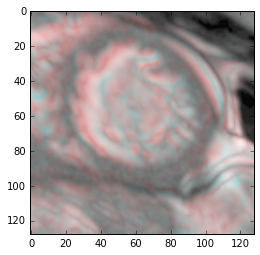

In [25]:
from keras.preprocessing.image import random_shift, random_rotation

study=268
(xs, _), ys, angle = Xresults[study]
x0 = xs[:,:,:,:].copy()

sft=int(S*shift_range)
zm = (1+zoom_range)
x0 = transform(x0, angle=rotation_range, shear=shear_range,zoom=zm,out_shape=(S0,S0),shift_x=sft, shift_y=sft)
print x0.shape
# x0 = crop(x0)
color_show(x0[3])
x0.shape

In [26]:
if ch2:
    (_, xs), ys, angle = Xresults[12]
    x0 = xs[:,:,:,:].copy()

    sft=int(S*shift_range)
#     sft=0
    zm = (1+zoom_range)/2.
    x0 = transform(x0, angle=rotation_range, shear=shear_range,zoom=zm,out_shape=(S0,S0),shift_x=sft, shift_y=sft)
    print x0.shape
    # x0 = crop(x0)
    color_show(x0[0])
    print x0.shape

In [27]:
ymean, ystd = Y.mean(axis=0), Y.std(axis=0)
ymean, ystd

(array([  71.13735714,  164.12514286]), array([ 42.05328406,  59.017804  ]))

In [28]:
ymean, ystd = (np.array([  71.96  ,  165.8668]), np.array([ 43.24805568,  59.27725076]))

## generator

In [29]:
T, WW is not None

(2, True)

In [30]:
from keras.preprocessing.image import ImageDataGenerator

class GraphImageDataGenerator2(ImageDataGenerator):
    def __init__(self,label_range=0.,zoom_range=0.,scale_range=0.,random_slice=False,random_time=False,with_std=False,**kwargs):
        self.label_range = label_range
        self.zoom_range = zoom_range
        self.scale_range = scale_range
        self.random_slice = random_slice
        self.with_std=with_std
        self.random_time = random_time
        super(GraphImageDataGenerator2, self).__init__(**kwargs)

    def flow(self, X, C=C, CC=CC, **kwargs):
        """
        C=0 # generate all slices from a single example in a batch
        C=8 # number of examples in a batch from same study (use power of 2)
        CC=1 # number of slices in each example
        """
        self.C = C
        self.CC = CC
        if C:
            batch_size = kwargs['batch_size']
            assert batch_size % C == 0
            kwargs['batch_size'] = batch_size // C
        else:
            assert kwargs['batch_size'] == 1
        
        return super(GraphImageDataGenerator2,self).flow(X, X, **kwargs)
    
    def next(self):
        # Keep under lock only the mechainsem which advance the indexing of each batch
        # see # http://anandology.com/blog/using-iterators-and-generators/
        with self.lock:
            index_array, current_index, current_batch_size = next(self.flow_generator)
        bX = []
        if ch2:
            bX_2ch = []
        bY = []
        bYscale = []
        C = self.C
        CC = self.CC
        assert C > 0 or current_batch_size == 1
        for idx in index_array:
            study = self.X[idx]
            (x, x_2ch), yscale, angle = Xresults[study]
            nx = len(x)-CC+1 # number of slices we can use
            Cx = nx if C == 0 else C # number of slices we want
            if nx == Cx or not self.random_slice:
                slices = np.linspace(0,nx-1,Cx).astype(int)
            elif nx > Cx:
                # we have more slices than we want, take without repeation
                slices = np.sort(random.sample(xrange(nx),Cx))
            else:
                # We have less than we want.
                # first make sure we take all we have
                slices = range(nx)
                # add more slices without repeation
                slices += random.sample(xrange(nx),min(Cx-nx,nx))
                if len(slices) < Cx:
                    # if we need more then add with repeation
                    slices += list(np.random.choice(nx,Cx-len(slices)))
                slices = np.sort(slices)
            # make sure the first/last slice are always selected
            slices[0] = 0
            slices[-1] = nx-1
                            
            for j,slc in enumerate(slices):
                # process one example
                slc_range = range(slc,slc+CC)
                if T > 0:
                    if WW is not None:
                        time_range = range(2*T+1)
                    elif self.random_time:
                        time_range = [np.random.randint(2*T+1), 2*T+1+np.random.randint(2*T+1)]
                    else:
                        time_range = [T,3*T+1]
                else:
                    time_range = range(x.shape[1])
                x0 = np.array([x[s,t]/256. for s in slc_range for t in time_range])
                if ch2:
                    x0_2ch = np.array([x_2ch[0,t]/256. for t in time_range])
                
                angle0 = angle + np.random.uniform(-self.rotation_range, self.rotation_range)
                shear = np.random.uniform(-self.shear_range, self.shear_range)
                shift_x = int(S*np.random.uniform(-self.self.width_shift_range, self.self.width_shift_range))
                shift_y = int(S*np.random.uniform(-self.self.height_shift_range, self.self.height_shift_range))
                zoom = np.exp(np.random.uniform(np.log(1./(1.+self.zoom_range)), np.log(1.+self.zoom_range)))
                x0 = transform(x0, angle=angle0, shear=shear, zoom=zoom,
                               out_shape=(S0,S0),
                               shift_x=shift_x, shift_y=shift_y)
                
                if ch2:
                    # use different augmentation for 2ch than for sax except for zoom because we want them to have same scale
                    # ignore the 2D sax angle
                    angle0 = np.random.uniform(-self.rotation_range, self.rotation_range)
                    shear = np.random.uniform(-self.shear_range, self.shear_range)
                    shift_x = int(S*np.random.uniform(-self.self.width_shift_range, self.self.width_shift_range))
                    shift_y = int(S*np.random.uniform(-self.self.height_shift_range, self.self.height_shift_range))
                    # keep the same propotyion of zoom as sax
                    if np.random.randint(2):
                        for i in range(x0_2ch.shape[0]):
                            x0_2ch[i] = np.fliplr(x0_2ch[i])
                    x0_2ch = transform(x0_2ch, angle=0, shear=shear, zoom=zoom/2.,
                                   out_shape=(S0,S0),
                                   shift_x=shift_x, shift_y=shift_y)

                if self.scale_range:
                    s = np.exp(np.random.uniform(np.log(1./(1.+self.scale_range)), np.log(1.+self.scale_range)))
                    x0 *= s
                    if ch2:
                        s = np.exp(np.random.uniform(np.log(1./(1.+self.scale_range)), np.log(1.+self.scale_range)))
                        x0_2ch *= s
                ys = yscale / (zoom*zoom)
                
                bX.append(x0)
                if ch2:
                    bX_2ch.append(x0_2ch)

                if study < Ntraining:
                    y0 = Y[study, :]
                    y0 = y0/ystd  # dont use ymean because we cant make predictions using the same CNN for different yscale
                    if self.label_range:
                        r = np.exp(np.random.uniform(np.log(1./(1.+self.label_range)), np.log(1.+self.label_range)))
                        y0 *= r
                else:
                    y0 = np.zeros(2)
                # distances in slices between slice of current example and the next example
                s = slices[j+1]-slc if j < Cx-1 else len(x)-CC-slc
                if self.with_std:
                    # dummy space for the logstd prediction
                    y0 = np.concatenate((y0,np.ones(len(y0)),np.array([ys,s])))
                else:
                    y0 = np.concatenate((y0,np.array([ys,s])))
                bY.append(y0)
                bYscale.append([ys,s])
            
        bX = np.array(bX) 
        if ch2:
            bX_2ch = np.array(bX_2ch) 
        bY = np.array(bY)
        bYscale = np.array(bYscale)
        if ch2:
            return {'input':bX, 'input_2ch':bX_2ch, 'output':bY, 'yscale':bYscale}
        else:
            return {'input':bX, 'output':bY, 'yscale':bYscale}
                    
traingen = GraphImageDataGenerator2(with_std=with_std,
                                    featurewise_center=False, featurewise_std_normalization=False,
                                     rotation_range=rotation_range, label_range=label_range,
                                    width_shift_range=shift_range, height_shift_range=shift_range,
                                    zoom_range=zoom_range, scale_range=scale_range, shear_range=shear_range,
                                    random_slice=True,random_time=True)
valgen = GraphImageDataGenerator2(with_std=with_std,
                                  featurewise_center=False, featurewise_std_normalization=False)

## testing

In [31]:
f = traingen.flow(np.arange(Ntraining), batch_size=8*C, shuffle=False)

In [32]:
data = next(f)  # get a single batch

In [33]:
data.keys()

['input', 'yscale', 'output']

In [34]:
data['output'][0]

array([  2.50518191,   4.16349928,   1.        ,   1.        ,
        11.41161786,   1.        ])

In [35]:
data['yscale'][0]

array([ 11.41161786,   1.        ])

In [36]:
print data['input'].shape
if ch2:
    print data['input_2ch'].shape

(80, 5, 128, 128)


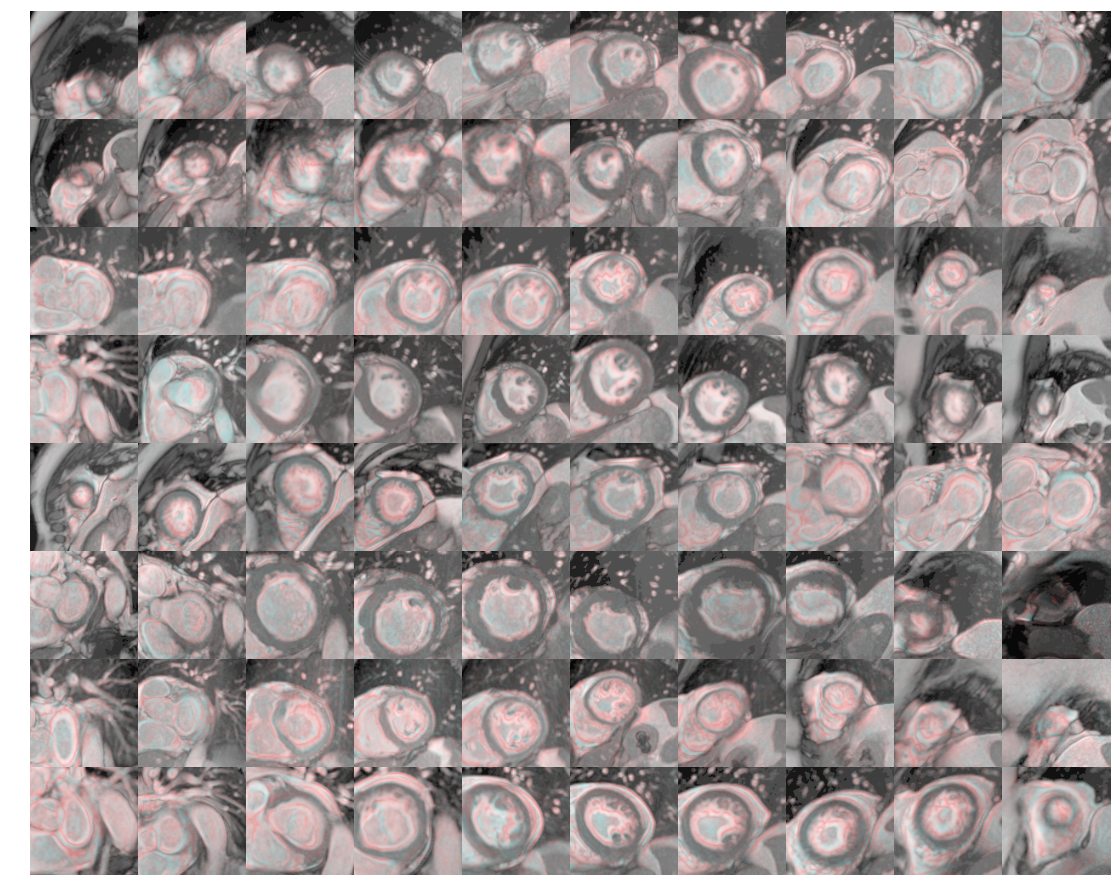

In [37]:
nC = len(data['input'])
plt.figure(figsize=(15,12))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
for c in range(nC):
    plt.subplot(nC//C,C,c+1)
    color_show(data['input'][c])
    plt.axis('off')

In [38]:
if ch2:
    nC = len(data['input_2ch'])
    plt.figure(figsize=(15,12))
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    for c in range(nC):
        plt.subplot(nC//C,C,c+1)
        color_show(data['input_2ch'][c])
        plt.axis('off')

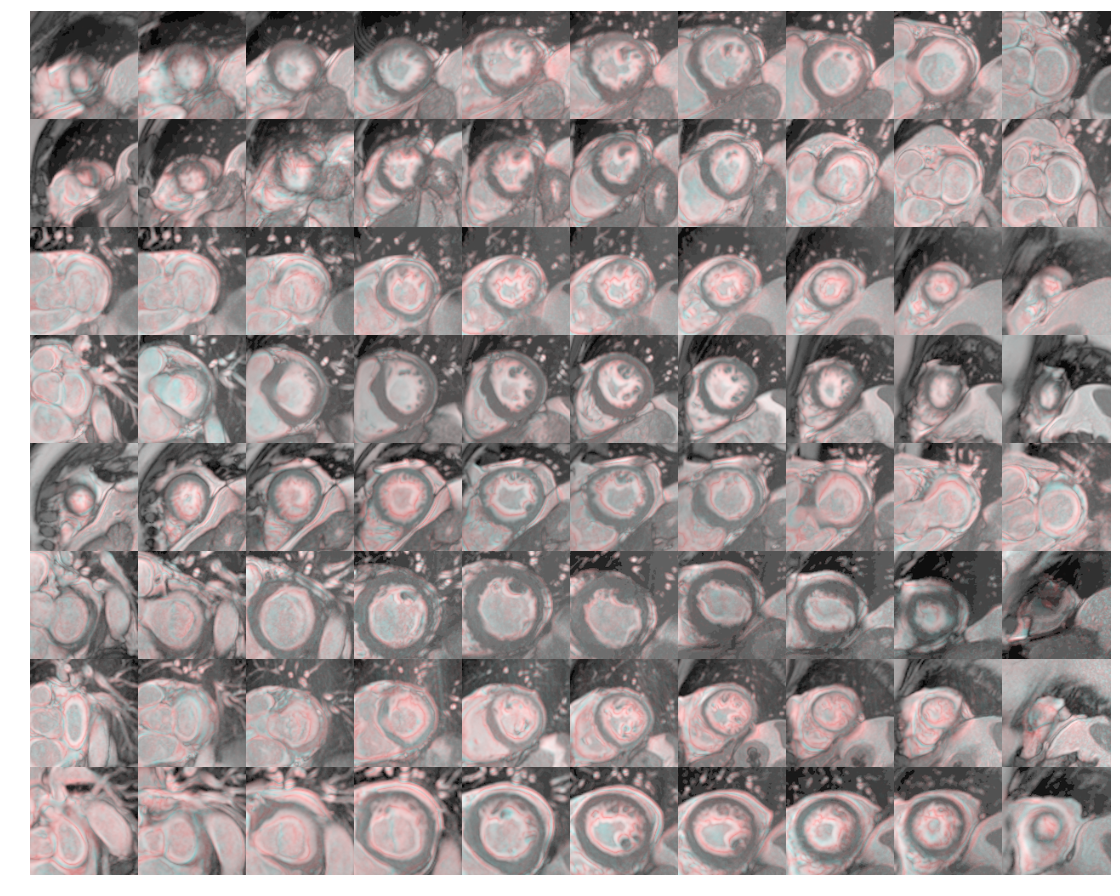

In [39]:
f = valgen.flow(np.arange(Ntraining), batch_size=8*C, shuffle=False)
data = next(f)  # get a single batch
nC = len(data['input'])
plt.figure(figsize=(15,12))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
for c in range(nC):
    plt.subplot(nC//C,C,c+1)
    color_show(data['input'][c])
    plt.axis('off')

In [40]:
input_shape = data['input'].shape[1:]
print input_shape
if ch2:
    input_2ch_shape = data['input_2ch'].shape[1:]
    print input_2ch_shape

(5, 128, 128)


In [41]:
output_dim = data['output'].shape[1]
output_dim

6

In [42]:
yscale_dim = data['yscale'].shape[1]
yscale_dim

2

# model

In [43]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Merge
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras.regularizers import l2

def gen_model(input_shape):
    model = Sequential()
#     model.add(Activation(activation=center_normalize, input_shape=input_shape))

    model.add(Convolution2D(64, 1, 1, border_mode='same', input_shape=input_shape))
#     model.add(BatchNormalization())
#     model.add(ELU())
    model.add(Activation('relu')) # Activation('relu')
    model.add(Convolution2D(64, 3, 3, border_mode='valid',subsample=(2,2)))
#     model.add(ELU()) # Activation('relu')
    model.add(BatchNormalization())
    model.add(Activation('relu')) # Activation('relu')
#     model.add(ZeroPadding2D(padding=(1, 1)))
#     model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Convolution2D(96, 3, 3, border_mode='same'))
#     model.add(BatchNormalization())
#     model.add(ELU())
    model.add(Activation('relu')) # Activation('relu')
    model.add(Convolution2D(96, 3, 3, border_mode='valid',subsample=(2,2)))
    model.add(BatchNormalization())
    model.add(Activation('relu')) # Activation('relu')
#     model.add(ELU())
#     model.add(ZeroPadding2D(padding=(1, 1)))
#     model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Convolution2D(128, 2, 2, border_mode='same'))
#     model.add(BatchNormalization())
    model.add(Activation('relu')) # Activation('relu')
#     model.add(ELU())
    model.add(Convolution2D(128, 2, 2, border_mode='valid',subsample=(2,2)))
    model.add(BatchNormalization())
    model.add(Activation('relu')) # Activation('relu')
#     model.add(ELU())
#     model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Convolution2D(128, 2, 2, border_mode='same'))
#     model.add(BatchNormalization())
    model.add(Activation('relu')) # Activation('relu')
#     model.add(ELU())
    model.add(Convolution2D(128, 2, 2, border_mode='valid',subsample=(2,2)))
    model.add(BatchNormalization())
    model.add(Activation('relu')) # Activation('relu')
#     model.add(ELU())
#     model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    return model

Using Theano backend.
Using gpu device 0: GRID K520 (CNMeM is disabled, CuDNN 4004)


https://github.com/fchollet/keras/pull/928

http://keras.io/layers/core/#siamese

https://gist.github.com/mmmikael/b202b344b1c89dbbce64

In [44]:
# seed the weight initializations and dropout internal seed
random.seed(seed)
np.random.seed(seed)

from keras.models import Graph

graph = Graph()

graph.add_input(name='input', input_shape=input_shape)
graph.add_node(gen_model(input_shape), name='model', input='input')

if ch2:
    graph.add_input(name='input_2ch', input_shape=input_2ch_shape)
    graph.add_node(gen_model(input_2ch_shape), name='model_2ch', input='input_2ch')

if ch2:
    graph.add_node(Dense(DENSE, W_regularizer=l2(L2)), name='fc1', inputs=['model','model_2ch'])
else:
    graph.add_node(Dense(DENSE, W_regularizer=l2(L2)), name='fc1', input='model')
graph.add_node(BatchNormalization(),name='fc1_bn',input='fc1')
graph.add_node(Activation('relu'),name='fc1_act',input='fc1_bn')
graph.add_node(Dropout(0.5), name='fc1_dropout',input='fc1_act')

if with_fc2:
    graph.add_node(Dense(DENSE, W_regularizer=l2(L2)), name='fc2', input='fc1_dropout')
    graph.add_node(BatchNormalization(),name='fc2_bn',input='fc2')
    graph.add_node(Activation('relu'),name='fc2_act',input='fc2_bn')
    graph.add_node(Dropout(0.5), name='fc2_dropout',input='fc2_act')
    last_fc_layer = 'fc2_dropout'
else:
    last_fc_layer = 'fc1_dropout'

# predict sys and dia together
graph.add_node(Dense(output_dim-yscale_dim),name='volume', input=last_fc_layer)

graph.add_input(name='yscale', input_shape=(yscale_dim,))

graph.add_node(Activation('linear'), inputs=['volume','yscale'], name='output', merge_mode='concat', create_output=True)

In [45]:
from keras.objectives import mse
import keras.backend as K

# Square of minimal error dividend by std normalization (~50ml)
# Square of minimal error dividend by std normalization (~50ml)
min_var=0.001 # ~1.6ml
CLIP=0.5 # dont allow negative values

def nll(y,mean,var):
    return K.mean(K.log(var) + K.square(y - mean + K.minimum(mean,0))/var + CLIP*K.square(K.minimum(mean,0)), axis=-1) 

def np_nll(y,mean,var):
    return np.mean(np.log(var) + np.square(y - mean)/var + CLIP*np.square(np.minimum(mean,0)), axis=-1) 

def nll_study(y_true, y_pred,C=C, output_dim=output_dim, yscale_dim=yscale_dim):
    """
    y - [sys, dia, logstd-sys, logstd-dia, yscale, yslice]
    """
    assert yscale_dim == 2 and output_dim == 6

    # collapse the true values to one value per example.
    y_true1 = K.mean(K.reshape(y_true, (y_true.shape[0]/C, C, output_dim)), axis=1)
    
    y_pred = K.reshape(y_pred, (y_pred.shape[0]/C, C, output_dim))
    yscale = y_pred[:,:,output_dim-2].dimshuffle([0,1,'x'])
    yslice = y_pred[:,:-1,output_dim-1].dimshuffle([0,1,'x'])
#     yslice_mask = K.clip(yslice,0,1)

    # the sys and dia of every slice have different yscale
    y_mean = y_pred[:,:,:2] * yscale
    # average area between each pair of slices
    y_mean = (y_mean[:,:-1,:] + y_mean[:,1:,:])/2. # + K.sqrt(y_pred[:,:-1,:2]*y_pred[:,1:,:2]))/3.
    # multiply by the height of each pair of slices
    y_mean = y_mean * yslice
    # volume along slices
    y_mean = K.sum(y_mean, axis=1) # /K.sum(yslice, axis=1)

    # convert form logsigma to sigma and scale
    y_sigma = K.exp(y_pred[:,:,2:4]) * yscale
    # convert to variance
    y_var = K.square(y_sigma)
    # variance of pair average
    y_var = (y_var[:,:-1,:] + y_var[:,1:,:])/2. # + K.sqrt(y_pred[:,:-1,:2]*y_pred[:,1:,:2]))/3.
    # correct for height of pair
    # Below should be yslice*yslice but we are simulating a missing slice which is uncorelated 
    # emprical comparisong between using large C and small C shows that using just yslice is better
    y_var = y_var * yslice
    # variance along slices
    y_var = K.sum(y_var, axis=1) # /K.sum(yslice_mask, axis=1)
    y_var += min_var

    # compute negative log liklihood (NLL) of true values given mean and variance
    loss0 = nll(y_true1[:,0], y_mean[:,0], y_var[:,0])
    loss1 = nll(y_true1[:,1], y_mean[:,1], y_var[:,1])
    return (loss0 + loss1)/2.

def np_study(y_pred,C=C, output_dim=output_dim, yscale_dim=yscale_dim):
    # compute mean and std in the same way as nll_study with numpy instead of Theano
    assert yscale_dim == 2 and output_dim == 6
    
    y_pred = np.reshape(y_pred, (y_pred.shape[0]/C, C, output_dim))
    yscale = y_pred[:,:,output_dim-2][:,:,None]
    yslice = y_pred[:,:-1,output_dim-1][:,:,None]
#     yslice_mask = np.clip(yslice,0,1)

    y_mean = y_pred[:,:,:2] * yscale
    y_mean = (y_mean[:,:-1,:] + y_mean[:,1:,:])/2. # + K.sqrt(y_pred[:,:-1,:2]*y_pred[:,1:,:2]))/3.
    y_mean = y_mean * yslice
    y_mean = np.sum(y_mean, axis=1) # /np.sum(yslice, axis=1)

    y_sigma = np.exp(y_pred[:,:,2:4]) * yscale
    y_var = np.square(y_sigma)
    y_var = (y_var[:,:-1,:] + y_var[:,1:,:])/2. # + K.sqrt(y_pred[:,:-1,:2]*y_pred[:,1:,:2]))/3.
    y_var = y_var * yslice # * yslice
    y_var = np.sum(y_var, axis=1) # /np.sum(yslice_mask, axis=1)
    y_var += min_var
    
    return np.hstack((y_mean, np.sqrt(y_var)))

def mseC1(y_true, y_pred,C=C, output_dim=output_dim):
    y_true1 = K.mean(K.reshape(y_true, (y_true.shape[0]/C, C, output_dim)), axis=1)
    y_pred_mean = y_pred[:,:2]*y_pred[:,output_dim-1].dimshuffle([0,'x'])
    y_pred_mean = K.mean(K.reshape(y_pred_mean, (y_pred.shape[0]/C, C, 2)), axis=1)
    
    loss0 = mse(y_true1[:,0], y_pred_mean[:,0])
    loss1 = mse(y_true1[:,1], y_pred_mean[:,1])
    return (loss0 + loss1)/2.

def mean_squared_percentage_error(y_true, y_pred):
    var = 0.2*K.square(y_true)
    mean = y_pred
    y = y_true
    return K.mean(K.square(y - mean)/var + CLIP*K.square(K.minimum(mean,0)), axis=-1) 

def mseC(y_true, y_pred, C=C, output_dim=output_dim, yscale_dim=yscale_dim):
    assert yscale_dim == 2 and output_dim == 4

    y_true1 = K.mean(K.reshape(y_true, (y_true.shape[0]/C, C, output_dim)), axis=1)
    
    y_pred = K.reshape(y_pred, (y_pred.shape[0]/C, C, output_dim))
    yscale = y_pred[:,:,output_dim-2].dimshuffle([0,1,'x'])
    yslice = y_pred[:,:-1,output_dim-1].dimshuffle([0,1,'x'])

    y_pred = y_pred[:,:,:2] * yscale
    y_pred = (y_pred[:,:-1,:] + y_pred[:,1:,:])/2.
    #you cant because we removed mean + K.sqrt(y_pred[:,:-1,:2]*y_pred[:,1:,:2]))/3.
    y_pred = y_pred * yslice
    y_pred = K.sum(y_pred, axis=1) # /K.sum(yslice, axis=1)
    
    loss0 = mean_squared_percentage_error(y_true1[:,0], y_pred[:,0])
    loss1 = mean_squared_percentage_error(y_true1[:,1], y_pred[:,1])
    return (loss0 + loss1)/2.

# same unpacking of y_pred done by mseC but in numpy
def np_C(y_pred, C=C, output_dim=output_dim, yscale_dim=yscale_dim):
    assert yscale_dim == 2 and output_dim == 4
    
    y_pred = np.reshape(y_pred, (y_pred.shape[0]/C, C, output_dim))
    yscale = y_pred[:,:,output_dim-2][:,:,None]
    yslice = y_pred[:,:-1,output_dim-1][:,:,None]

    y_pred = y_pred[:,:,:2]*yscale
    
    y_pred = (y_pred[:,:-1,:] + y_pred[:,1:,:])/2.
    # + K.sqrt(y_pred[:,:-1,:2]*y_pred[:,1:,:2]))/3.
    y_pred = y_pred * yslice
    y_pred = np.sum(y_pred, axis=1) # /np.sum(yslice, axis=1)
    return y_pred

In [46]:
output_dim,C

(6, 10)

In [47]:
W_start = graph.get_weights()
W_start = [w.copy() for w in W_start]

In [48]:
from keras.optimizers import SGD, Adam
optimizer = Adam(lr=LR)
# optimizer = SGD(1e-5)

if output_dim == 6:
    loss = nll_study
elif output_dim == 4:
    loss = mseC
else:
    assert False
    
graph.compile(optimizer=optimizer, loss={'output': loss})

In [49]:
import random
idx = np.arange(Ntraining)
# seed the split
random.seed(seed)
np.random.seed(seed)
np.random.shuffle(idx)

In [50]:
split_size = Ntraining // 3
split_size

233

In [51]:
from scipy.stats import linregress
from tqdm import tqdm


def test_call(ipred, index):
    gen = valgen if ipred == 0 else traingen
    return next(gen.flow(np.array([index]), C=0, batch_size=1, shuffle=False))

def pred(itest, npred=1, seed=seed, n_jobs=-1):
    """
    npred  when making predictions perform 1 prediction using valgen and npred-1 using traingen and average
    n_jobs using value different from 1 may cause results to be underminstic
    """
    n = len(itest)
    if output_dim == 6:
        yp_corrected = np.zeros((n,4))
    elif output_dim == 4:
        yp_corrected = np.zeros((n,2))
    else:
        assert False
        
    if npred > 1:
        # reset seed so we will get demterminstic results when calling traingen
        last_seed = np.random.randint(10e6)
        random.seed(seed)
        np.random.seed(seed)
        
    # each batch will have all slices from the same example, different batches will have different size
    for i, index in enumerate(itest):
        # reset seed so we will get demterminstic results when calling traingen
        random.seed(seed)
        np.random.seed(seed)
        
        process = Parallel(n_jobs=n_jobs if npred > 1 else 1, verbose=0, backend='threading')
        test_data = process(delayed(test_call)(ipred,index) for ipred in range(npred))
        data = {}
        for d in test_data:
            for k,v in d.iteritems():
                if k in data:
                    data[k] = np.concatenate((data[k],v),axis=0)
                else:
                    data[k] = v

        nslices = len(data['input'])//npred
        assert nslices*npred == len(data['input'])
        predict = graph.predict(data, batch_size=nslices*npred)
        yp = predict['output']
        # collapse all slices to one result
        yp = np_study(yp, C=nslices) if output_dim == 6 else np_C(yp, C=nslices)
        assert len(yp) == npred
        if output_dim == 6:
            # move from std to var before avarging
            yp[:,2:4] = yp[:,2:4]**2
        yp = yp.mean(axis=0)
        
        yp_corrected[i,:2] = yp[:2]*ystd # we did not remove ymean and we dont add it here
        if output_dim == 6:
            # move back from var to std
            yp_corrected[i,2:4] = np.sqrt(yp[2:4])*ystd

    if npred > 1:
        # return seed to where it was so the training will not repeat itself
        random.seed(last_seed)
        np.random.seed(last_seed)

    return yp_corrected

def test_pred(itest, plot=False, npred=1, seed=seed, n_jobs=-1):
    yp_corrected = pred(itest, npred=npred, seed=seed, n_jobs=n_jobs)

    itest_in_Nt = np.where(itest < Ntraining)[0]
    rmse = 0.
    avg_score = 0.
    if len(itest_in_Nt):
        itest0 = itest[itest_in_Nt]
        for measure in range(2):
            r = np.sqrt(np.mean(np.square(yp_corrected[itest_in_Nt,measure]-Y[itest0,measure])))
            rmse += r/2.
            print "RMSE", r,
            print linregress(Y[itest0,measure], yp_corrected[itest_in_Nt,measure])
            if plot:
                if measure == 0:
                    plt.figure(figsize=(12,5))
                plt.subplot(1,2,measure+1)
                if output_dim == 6:
                    plt.errorbar(Y[itest0,measure],yp_corrected[itest_in_Nt,measure],
                                 yerr=yp_corrected[itest_in_Nt,measure+2],
                                 fmt='.',alpha=0.3)
                else:
                    plt.scatter(Y[itest0,measure],yp_corrected[itest_in_Nt,measure])
            if output_dim == 6:
                score = np_nll(yp_corrected[itest_in_Nt,measure]/ystd[measure],
                               Y[itest0,measure]/ystd[measure],
                               (yp_corrected[itest_in_Nt,measure+2]/ystd[measure])**2)
                print 'score',score
                avg_score += score/2.
        print 'avg', rmse, avg_score

    return yp_corrected, rmse, avg_score

In [52]:
from keras.callbacks import Callback

class SaveBestModel(Callback):
    def __init__(self, fn, isplit, start=0, histories=[], best_val_loss=np.Inf):
        super(Callback, self).__init__()

        self.epoch_counter = start
        self.fn = fn
        self.isplit = isplit
        self.histories = histories
        self.best_val_loss = best_val_loss

    def on_epoch_end(self, epoch, logs={}):
        i = self.epoch_counter
        self.epoch_counter += 1
        isplit = self.isplit
        
        val_loss_label = 'val_loss' if isplit >= 0 else 'loss'
        val_loss = logs.get(val_loss_label)
        self.histories.append((logs.get('loss'),val_loss))

        fname = '%s.history.%d.pkl'%(self.fn,isplit)
        with open(os.path.join(temp_dir,fname), 'wb') as fp:
            pickle.dump(self.histories,fp,-1)
        awscp(fname, upload=True)            

        if val_loss < self.best_val_loss:
            print val_loss
            print
            test_pred(itest)
            self.best_val_loss = val_loss
            fname = '%s.weights.iter-%d.%d.hdf5'%(self.fn,i,isplit)
            print "SAVING MODEL", self.best_val_loss
            self.model.save_weights(os.path.join(temp_dir,fname), overwrite=True)
            awscp(fname, upload=True)

# Cross Validation

In [53]:
batch_size = C*5 # must be a multiple of C

In [54]:
# this version of set/load weights is capable of doing transfer learning by
# copying just the bottom layers from a model which has a different
# top structure.
def set_weights(graph, weights):
    for i, layer in enumerate(graph.nodes.values()):
        nb_param = len(layer.get_weights())
        try:
            layer.set_weights(weights[:nb_param])
            weights = weights[nb_param:]
        except:
            print "load failed at", i
            break
            
def load_weights(graph, filepath):
    '''Load weights from a HDF5 file.
    '''
    import h5py
    f = h5py.File(filepath)
    g = f['graph']
    weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
    set_weights(graph, weights)
    f.close()   

In [55]:
if isplit >= 0:
    istart = isplit*split_size
    if isplit < 2 and isplit >= 0:
        iend = (isplit+1)*split_size
    else:
        iend = Ntraining
    itest = idx[istart:iend]
    itrain = np.concatenate((idx[0:istart],idx[iend:Ntraining]), axis=0)
    validation_data = next(valgen.flow(itest, batch_size=len(itest)*C, shuffle=False))
else:
    itest = np.arange(Ntraining)        
    itrain = np.arange(Ntraining)
    # small validation set just to make the code the same for all and split
    validation_size = 4
    validation_data = next(valgen.flow(np.arange(validation_size), batch_size=validation_size*C, shuffle=False))

In [56]:
start

0

In [61]:
if pre_load:
    print 'Loading', pre_load
    fname = os.path.join(temp_dir, pre_load)
    load_weights(graph, fname)
    _, _, avg_score = test_pred(itest, plot=True, npred=1);
    callback =  SaveBestModel(FN, isplit, start=start, best_val_loss=avg_score)
else:
    graph.set_weights(W_start)
    assert start == 0
    callback =  SaveBestModel(FN, isplit)

In [ ]:
if start == 0:
    # seed the generator flow
    random.seed(seed)
    np.random.seed(seed)

gen = traingen.flow(itrain, batch_size=batch_size, shuffle=True)

nb_epoch = NB_EPOCH_0 - start
if nb_epoch > 0:
    graph.fit_generator(gen,
                    samples_per_epoch=len(itrain)*C,
                    nb_epoch=nb_epoch, verbose=1,
                    validation_data=validation_data,
                    nb_worker=8, callbacks=[callback])

Epoch 1/500
 250/4670 [>.............................] - ETA: 256s - loss: 6.5772

In [ ]:
nb_epoch = NB_EPOCH_1
if start > NB_EPOCH_0:
    nb_epoch -= start - NB_EPOCH_0

if nb_epoch > 0:
    optimizer = Adam(lr=LR/3.)
    graph.compile(optimizer=optimizer, loss={'output': loss})        
    graph.fit_generator(gen,
                    samples_per_epoch=len(itrain)*C,
                    nb_epoch=nb_epoch, verbose=1,
                    validation_data=validation_data,
                    nb_worker=8, callbacks=[callback])

# Predict

In [ ]:
fn0 = '%s.weights.iter-'%FN
odir = out_dir
if not odir.endswith('/'):
    odir += '/'
if out_dir.startswith('s3://'):
    res = !aws s3 ls {odir} | grep {fn0} | grep {'.%d.hdf5'%isplit}
else:
    res = !ls -1 {odir} | grep {fn0} | grep {'.%d.hdf5'%isplit}
res = [r.split()[-1] for r in res]

def widx(x):
    return -int(x.split('.')[-3].split('-')[1])
res = sorted(res,key=widx)[0]
itr0 = -widx(res)

pre_load = res
print pre_load
awscp(pre_load)

In [ ]:
itr0

In [ ]:
fname = os.path.join(temp_dir, pre_load)
load_weights(graph, fname)

yp_corrected, _, _ = test_pred(itest, plot=True, npred=12, seed=seed, n_jobs=-1) # npred=12 is better (in jumps of 4)

yp_test, _, _ = test_pred(np.arange(Ntraining,Na), npred=12, seed=seed, n_jobs=-1)

In [ ]:
fname_yp = '%s.yp.iter-%d.%d.pkl'%(FN,itr0,isplit)
print fname_yp

with open(os.path.join(temp_dir, fname_yp), 'wb') as fp:
    pickle.dump((yp_corrected,Y[itest],itest,yp_test),fp,-1)
awscp(fname_yp, upload=True)

# Finish

Self terminate if running on AWS EC2 instance.

In [ ]:
!aws ec2 terminate-instances --instance-ids `curl http://169.254.169.254/latest/meta-data/instance-id`